In [3]:
import sys
sys.path.append("../")
from os.path import join
from IPython.display import display
import os
from collections import OrderedDict
import json

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=False)

import scipy
import faiss
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from lolip.models.torch_utils import archs
from lolip.variables import auto_var
from lolip.extra_ood_utils import get_ood_data_paths

pd.set_option('display.max_rows', 200)


fontsize=15

# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2


_, ood_names = get_ood_data_paths("imgnet", "/tmp2")

# feature (nowo)

In [2]:
preds, nnidxs, dists = joblib.load("nb_results/feature-imgnet-c.pkl")

ori_dset = torchvision.datasets.ImageFolder("/tmp2/ImageNet100/ILSVRC2012_img_train/")
image_folders, ood_names = get_ood_data_paths("imgnet", "/tmp2")

dset = torchvision.datasets.ImageFolder(
    image_folders[0],
    transforms.Compose([transforms.Resize(128), transforms.CenterCrop(112), transforms.ToTensor(), ])
)
_loader = torch.utils.data.DataLoader(dset, batch_size=64, shuffle=False, num_workers=24)
ty = np.concatenate([y.numpy() for (_, y) in _loader])

valid_classes = []
for c in ori_dset.classes:
    valid_classes.append(dset.class_to_idx[c])
assert len(valid_classes) == 100
imgnet100_idx = np.array([i for i, c in enumerate(ty) if c in valid_classes])
            
preds = {k: {kk: (vv[imgnet100_idx] if kk != "tst" else vv) for kk, vv in v.items()} for k, v in preds.items()}
nnidxs = {k: {kk: (vv[imgnet100_idx] if kk != "tst" else vv) for kk, vv in v.items()} for k, v in nnidxs.items()}
dists = {k: {kk: (vv[imgnet100_idx] if kk != "tst" else vv) for kk, vv in v.items()} for k, v in dists.items()}
joblib.dump((preds, nnidxs, dists), "nb_results/feature-imgnet100-c.pkl")

['nb_results/feature-imgnet100-c.pkl']

## nat vs. rob

In [5]:
preds, nnidxs, dists = joblib.load("nb_results/feature-imgnet100-c.pkl")

datasets = ["calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl"]

model_names = ['natural', 'TRADES(2)',]

data = {}
for ds_name in datasets:
    _, trny, _, _, _ = auto_var.get_var_with_argument("dataset", ds_name)
    for model_name in model_names:
        key = (ds_name, model_name)
        if key not in preds:
            print(f"skipping {key}")
            continue
            
        for ood_name in ood_names:
            res = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])

            ood_name, i = ood_name.split("_")
            data[(ds_name, model_name, ood_name, int(i))] = res.mean()

100%|██████████| 157/157 [00:01<00:00, 93.64it/s] 


### Aggregated

In [4]:
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)']

df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
df = df.unstack(3).unstack(2)
df.columns = df.columns.droplevel(0)
results = {}
for dset, dd in df.groupby("dataset"):
    for model_name in model_names[1:]:
        results[(dset, model_name)] = [
            (np.array((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist()) > 0).sum(),
            "$%.2f \pm %.2f$" % (
                np.mean((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist()),
                scipy.stats.sem((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist())
            ),
            "$%.2f \pm %.2f$" % (
                np.mean((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist()),
                scipy.stats.sem((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist())
            ),
        ]
ddff = pd.DataFrame.from_dict(results, orient="index", columns=["counts", "difference", "ratio"])
ddff.index = pd.MultiIndex.from_tuples(ddff.index, names=["dataset", "model"])
ddff = ddff[["difference", "ratio"]]
ddff = ddff.unstack(1)
text = ddff.to_latex(escape=False)
text = text.replace("calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl", "I")
text = text.replace("}{l}", "}{c}")
text = text.replace("0.", ".")
text = text.replace("lllllllll", "lcccc|cccc")
text = text.replace("lllllll", "lccc|ccc")
print(text)

\begin{tabular}{lll}
\toprule
{} &       difference &            ratio \\
model &        TRADES(2) &        TRADES(2) \\
dataset                                            &                  &                  \\
\midrule
calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgne... &  $.01 \pm .00$ &  $1.09 \pm .01$ \\
\bottomrule
\end{tabular}



## NCG correct vs. NCG incorrect

In [23]:
ys = {}
preds, nnidxs, dists = joblib.load("nb_results/feature-imgnet100-c.pkl")

In [4]:
#preds, nnidxs, dists = joblib.load("nb_results/imgnet.pkl")
#model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)',]

data = {}
for key in sorted(preds.keys()):
    print(key)
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    if ds_name not in ys:
        _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
        ys[ds_name] = (trny, tsty)
    else:
        trny, tsty = ys[ds_name]
        
    for ood_name in ood_names:
        ncg_ind = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
        tstacc_ind = (preds[key][ood_name].argmax(1) == tsty)
        ori_ood_name = ood_name
        ood_name, i = ood_name.split("_")

        ttest = scipy.stats.ttest_ind(
            np.logical_and(tstacc_ind, ncg_ind)[ncg_ind == 1],
            np.logical_and(tstacc_ind, ncg_ind == 0)[ncg_ind == 0],
            equal_var=False,
            alternative="greater",
        )
        data[(key[0], key[1], ood_name, int(i))] = [
            ncg_ind.mean(),
            tstacc_ind.mean(),
            np.logical_and(tstacc_ind, ncg_ind).mean(),
            (np.logical_and(tstacc_ind, ncg_ind)[ncg_ind == 1]).mean(),
            (np.logical_and(tstacc_ind, ncg_ind == 0)[ncg_ind == 0]).mean(),
            ttest[0],
            ttest[1],
            dists[key][ori_ood_name].mean(),
        ]

('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl', 'TRADES(2)')


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl', 'natural')


In [13]:
table_text = ""
table_text_template = """
\\begin{table}
  \centering
  \input{%s}
  \caption{%s}
  \label{tab:%s}
\end{table}
"""

df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
tdd = df[["NCG acc.", "tst acc.", "[NCG correct] tst acc", "[NCG incorrect] tst acc"]]
dset_name = "calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl"
for ood_name in np.unique([name.split("_")[0] for name in ood_names]):
    tdd = df[["NCG acc.", "tst acc.", "[NCG correct] tst acc", "[NCG incorrect] tst acc"]]
    tdd = tdd.loc[
        [(dset_name, "natural", ood_name, i) for i in range(1, 6)]
        + [(dset_name, "TRADES(2)", ood_name, i) for i in range(1, 6)]
    ]
    tdd.index = tdd.index.droplevel(2)
    tdd = tdd.unstack(1)
    tdd.columns = tdd.columns.swaplevel(0, 1)
    tdd = tdd.sort_index(axis=1, level=0, ascending=False)
    text = tdd.to_latex(multirow=True, float_format="%.2f")
    text = text.replace(dset_name, "I")
    text = text.replace("NCG acc.", "\\thead{NCG \\\\ acc.}")
    text = text.replace("tst acc.", "\\thead{tst \\\\ acc.}")
    text = text.replace("[NCG correct] tst acc", "\\thead{NCG \\\\ correct \\\\ tst acc.}")
    text = text.replace("[NCG incorrect] tst acc", "\\thead{NCG \\\\ incorrect \\\\ tst acc.}")
    text = text.replace("[ttest] p-value", "\\thead{p-value}")
    text = text.replace("dist", "\\thead{dist}")
    text = text.replace("}{l}", "}{c}")
    text = text.replace("llrrrrrrrr", "lccccc|cccc")
    with open(f"./tex_files/corrupted_ncg_acc_inter/feature_imgnet100_{ood_name}.tex", "w") as fp:
        fp.write(text)
    table_text += table_text_template % (
        f"./tables/corrupted_ncg_acc_inter/feature_imgnet100_{ood_name}.tex",
        f"The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type {ood_name} in the pixel space for naturally trained and robsut models.",
        f"corrupted_ncg_acc_inter_feature_imgnet100_{ood_name}",
    )

In [12]:
print(table_text)


\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/feature_imgnet100_brightness.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type brightness in the pixel space for naturally trained and robsut models.}
  \label{tab:corrupted_ncg_acc_inter_feature_imgnet100_brightness}
\end{table}

\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/feature_imgnet100_contrast.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type contrast in the pixel space for naturally trained and robsut models.}
  \label{tab:corrupted_ncg_acc_inter_feature_imgnet100_contrast}
\end{table}

\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/feature_imgnet100_defocus.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type defocus in the pixel space for naturally 

### t-test

In [103]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
#for key, dd in df.groupby(['dataset', "model"]):
for key, dd in df.groupby(["model", "corruption"]):
    results[key] = (np.sum((dd["[ttest] t-stats"] > 0) & (dd["[ttest] p-value"] < 0.05)), len(dd["[ttest] t-stats"] > 0))

In [104]:
ttest_df = pd.DataFrame.from_dict(results, orient="index")
ttest_df.index = pd.MultiIndex.from_tuples(ttest_df.index, names=["model", "corruption"])
ttest_df.groupby("model").sum(1)

,0,1
model,,
TRADES(2),73,75
natural,73,75


In [107]:
#ttest_df.index = pd.MultiIndex.from_tuples(ttest_df.index, names=["corruption"])
ttest_df.transpose()

model       TRADES(2)                                                    \
corruption brightness contrast defocus elastic fog frost gaussian glass   
0                   5        3       5       5   5     5        5     5   
1                   5        5       5       5   5     5        5     5   

model                    ... natural                                     \
corruption impulse jpeg  ...   frost gaussian glass impulse jpeg motion   
0                5    5  ...       5        5     5       5    5      5   
1                5    5  ...       5        5     5       5    5      5   

model                               
corruption pixelate shot snow zoom  
0                 5    5    5    5  
1                 5    5    5    5  

[2 rows x 30 columns]

### control distance

In [26]:
model_names = ['natural', 'TRADES(2)']

bins = 5
control_dist_data = {}

ood_types = set(["".join(ood_name.split("_")[:-1]) for ood_name in ood_names])

for key in preds.keys():
    print(key)
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    if ds_name not in ys:
        _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
        ys[ds_name] = (trny, tsty)
    else:
        trny, tsty = ys[ds_name]
            
    for ood_type in ood_types:
        ncg_inds, tstacc_inds = [], []
        for i in range(5):
            ood_name = f"{ood_type}_{i+1}"
            ncg_inds.append(preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
            tstacc_inds.append(preds[key][ood_name].argmax(1) == tsty)
        ncg_ind = np.concatenate(ncg_inds)
        tstacc_ind = np.concatenate(tstacc_inds)
            
        ncg_dists = dists[key][ood_name]
        sort_idx = np.argsort(ncg_dists)
        idxs = []
        for i in range(bins):
            idxs.append(sort_idx[(i * len(sort_idx)) // bins: ((i+1) * len(sort_idx)) // bins])

        ttests, n_samples = [], []
        for i in range(bins):
            ttests.append(scipy.stats.ttest_ind(
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]])[ncg_ind[idxs[i]] == 1],
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]] == 0)[ncg_ind[idxs[i]] == 0],
                equal_var=False,
                alternative="greater",
            ))
            n_samples.append(np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]]).sum())
        control_dist_data[(key[0], key[1], ood_type)] = [ttests, n_samples]

('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl', 'natural')
('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl', 'TRADES(2)')


In [27]:
results = {}
for k, v in control_dist_data.items():
    results.setdefault((k[0], k[1]), np.zeros(bins))
    for i in range(bins):
        if (v[0][i][0] > 0) and (v[0][i][1] < 0.05):
            results[(k[0], k[1])][i] += 1
results

{('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl',
  'natural'): array([13., 13., 13., 14., 15.]),
 ('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl',
  'TRADES(2)'): array([12., 14., 14., 14., 15.])}

## Increase of corruption level

### test accuracy

In [108]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["tst acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [109]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(15):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='less'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([(t.statistic < 0.) for t in greater_ttests]))
        print(sum([((t.pvalue < 0.05) and (t.statistic < 0.)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl
TRADES(2)
9
0
15


### NCG accuracy

In [110]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["NCG acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [112]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(15):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='less'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([(t.statistic < 0.) for t in greater_ttests]))
        print(sum([((t.pvalue < 0.05) and (t.statistic < 0.)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl
TRADES(2)
6
0
13


### Slope figure

In [2]:
_, ood_names = get_ood_data_paths("imgnet", "/tmp2")

preds, nnidxs, dists = joblib.load("nb_results/feature-imgnet100-c.pkl")
data = {}

ds_name = f'aug10-imgnet100'
print(ds_name)
trnX, trny, tstX, tsty, _ = auto_var.get_var_with_argument("dataset", ds_name)


aug10-imgnet100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.64it/s]


In [9]:
preds.keys()

dict_keys([('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl', 'natural'), ('calcedrepr-aug10-imgnet100-cwl2-128-aug10-imgnet100-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl', 'TRADES(2)')])

In [10]:
data = {}
for key in preds.keys():
    _, model_name = key

    data[(ds_name, model_name, 'tst acc')] = [(preds[key]['tst'].argmax(1) == tsty).mean()]
    for i, ood_name in enumerate(ood_names):
        if ood_name not in preds[key]:
            #print(f"{key} missing {ood_name}")
            data[(ds_name, model_name, ood_name)] = [-1]
            data[(ds_name, model_name, f"dist_{ood_name}")] = [-1]
            data[(ds_name, model_name, f"tstacc_{ood_name}")] = [-1]
        else:
            data[(ds_name, model_name, ood_name)] = [(preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]]).mean()]
            data[(ds_name, model_name, f"dist_{ood_name}")] = [dists[key][ood_name].mean()]
            data[(ds_name, model_name, f"tstacc_{ood_name}")] = [(preds[key][ood_name].argmax(1) == tsty).mean()]

In [11]:
df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index)
df = df.unstack(2)
df.columns = df.columns.droplevel(0)

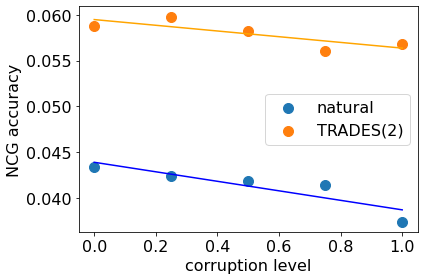

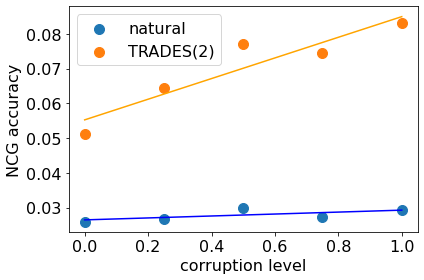

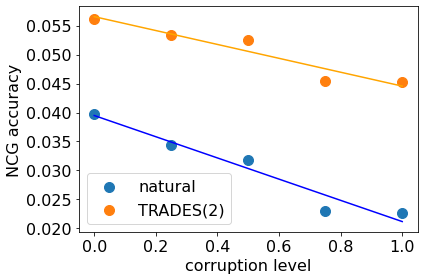

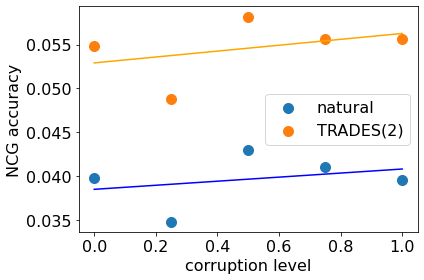

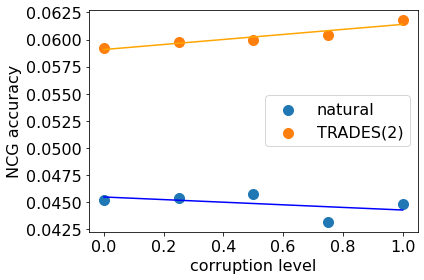

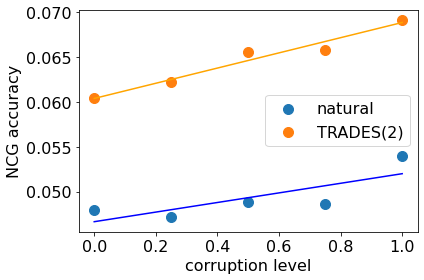

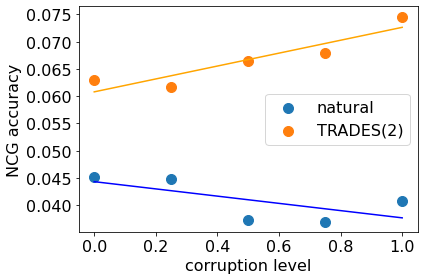

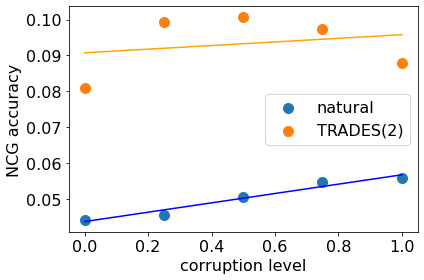

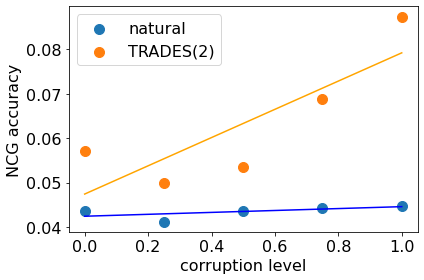

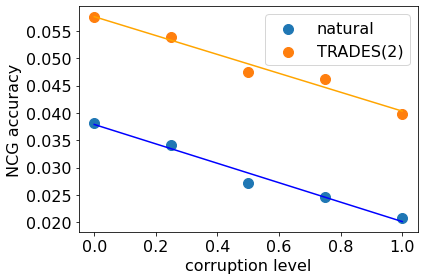

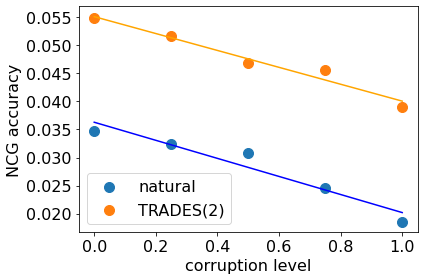

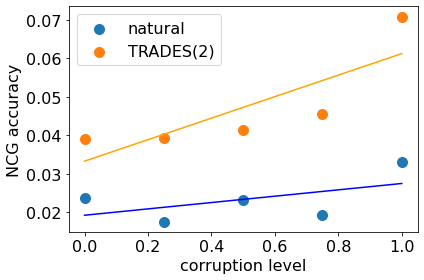

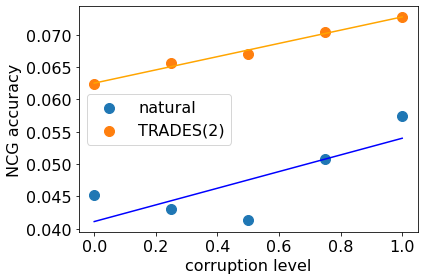

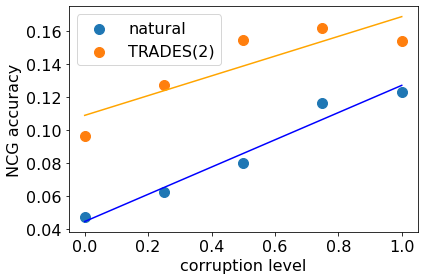

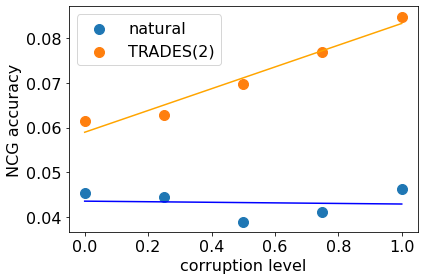

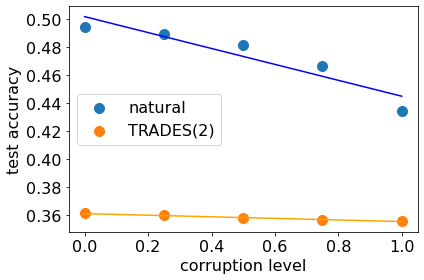

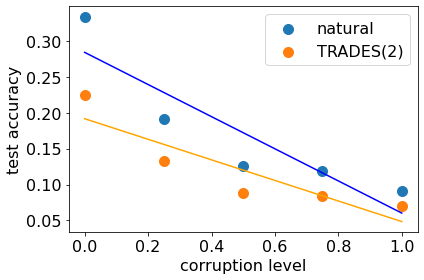

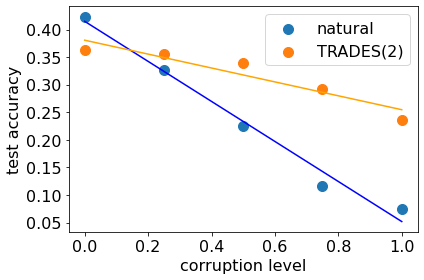

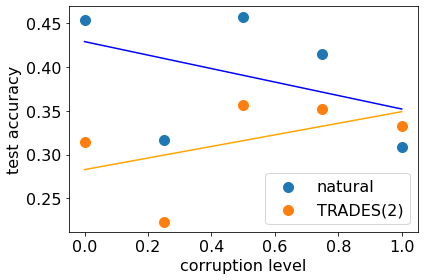

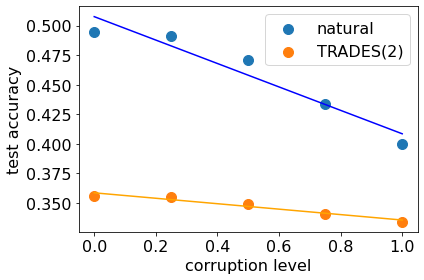

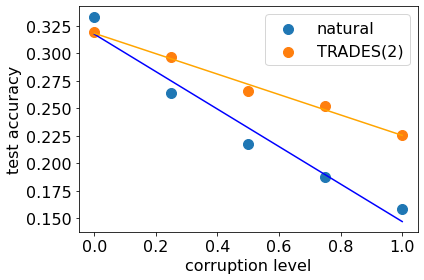

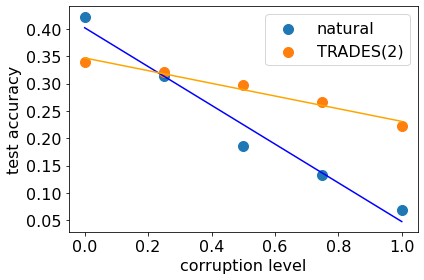

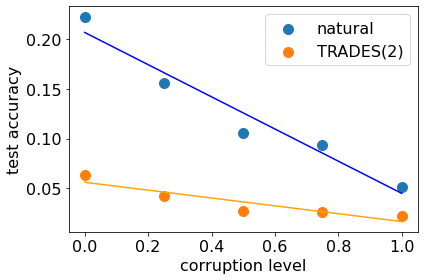

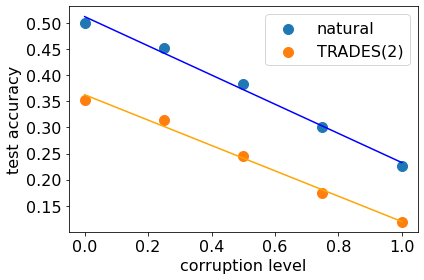

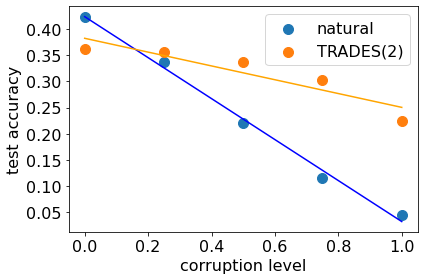

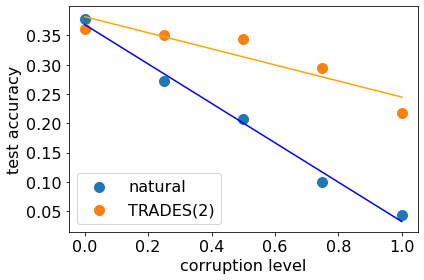

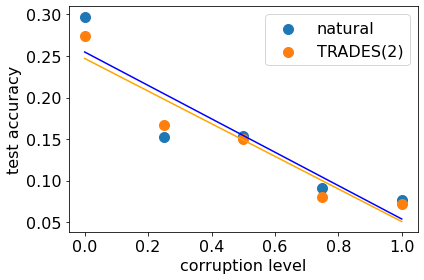

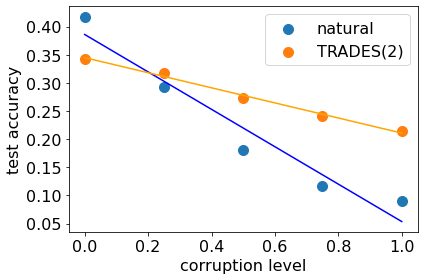

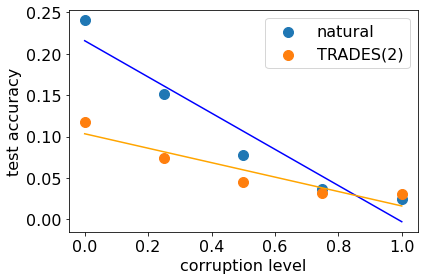

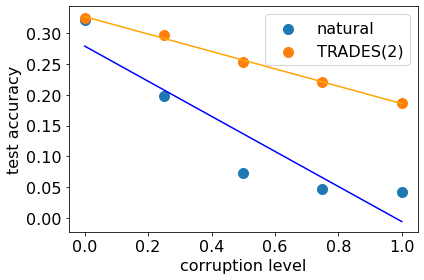

In [10]:
fontsize = 16
ds_names = ['aug10-imgnet100']
for metric in ["ncg", "tstacc"]:
    for ds_name in ds_names:
        for ood_name in set([ent.split("_")[0] for ent in ood_names]):
            if metric == "ncg":
                prefix = ""
            elif metric == "tstacc":
                prefix = "tstacc_"
            points = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[(ds_name, "natural")][[f"{prefix}{ood_name}_{i}" for i in range(1, 6)]].tolist()
            ]).T
            rob_pts = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[(ds_name, "TRADES(2)")][[f"{prefix}{ood_name}_{i}" for i in range(1, 6)]].tolist(),
            ]).T

            plt.scatter(points[:, 0], points[:, 1], s=100, label="natural")
            plt.scatter(rob_pts[:, 0], rob_pts[:, 1], s=100, label="TRADES(2)")

            def draw_regression_line(pts):
                gradient, intercept, _, _, _ = scipy.stats.linregress(pts[:, 0], pts[:, 1])
                x1=np.linspace(0, 1, 500)
                y1=gradient*x1 + intercept
                return gradient, x1, y1

            slope1, x1, y1 = draw_regression_line(points)
            plt.plot(x1, y1,'blue')
            slope2, x1, y1 = draw_regression_line(rob_pts)
            plt.plot(x1, y1,'orange')

            plt.legend(fontsize=fontsize)
            if metric == "ncg":
                plt.ylabel("NCG accuracy", fontsize=fontsize)
            elif metric == "tstacc":
                plt.ylabel("test accuracy", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            plt.xlabel("corruption level", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.tight_layout()
            slope1 = f"{slope1:.3f}".replace(".", "_")
            slope2 = f"{slope2:.3f}".replace(".", "_")
            plt.savefig(f"figs/slope_figs/feature_{metric}_{ds_name}_{ood_name}_{slope1}_{slope2}.png", bbox_inches='tight')
            plt.show()


#### distance vs. accuracy

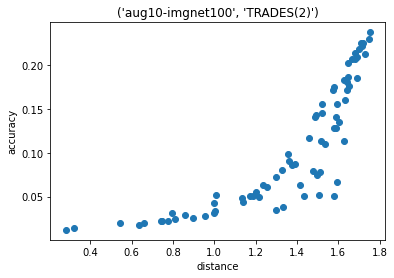

('aug10-imgnet100', 'TRADES(2)'): rho=0.826, p=0.000


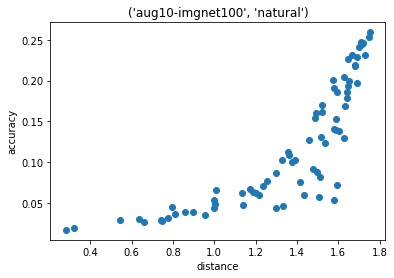

('aug10-imgnet100', 'natural'): rho=0.819, p=0.000


In [14]:
for i in range(2):
    aa = df[[f"dist_{ood_name}" for ood_name in ood_names]].iloc[i].tolist()
    bb = df[[f"tstacc_{ood_name}" for ood_name in ood_names]].iloc[i].tolist()
    plt.title(df.iloc[i].name)
    plt.scatter(aa, bb)
    plt.xlabel("distance")
    plt.ylabel("accuracy")
    plt.show()
    plt.close()
    res = scipy.stats.pearsonr(aa, bb)
    print(f"{df.iloc[i].name[0], df.iloc[i].name[1]}: rho={res[0]:.3f}, p={res[1]:.3f}")

# pixel (nowo)

In [ ]:
preds, nnidxs, dists = joblib.load("nb_results/nowo-imgnet-c.pkl")

ori_dset = torchvision.datasets.ImageFolder("/tmp2/ImageNet100/ILSVRC2012_img_train/")
image_folders, ood_names = get_ood_data_paths("imgnet", "/tmp2")

dset = torchvision.datasets.ImageFolder(
    image_folders[0],
    transforms.Compose([transforms.Resize(128), transforms.CenterCrop(112), transforms.ToTensor(), ])
)
_loader = torch.utils.data.DataLoader(dset, batch_size=64, shuffle=False, num_workers=24)
ty = np.concatenate([y.numpy() for (_, y) in _loader])

valid_classes = []
for c in ori_dset.classes:
    valid_classes.append(dset.class_to_idx[c])
assert len(valid_classes) == 100
imgnet100_idx = np.array([i for i, c in enumerate(ty) if c in valid_classes])
            
preds = {k: {kk: (vv[imgnet100_idx] if kk != "tst" else vv) for kk, vv in v.items()} for k, v in preds.items()}
nnidxs = {k: {kk: (vv[imgnet100_idx] if kk != "tst" else vv) for kk, vv in v.items()} for k, v in nnidxs.items()}
dists = {k: {kk: (vv[imgnet100_idx] if kk != "tst" else vv) for kk, vv in v.items()} for k, v in dists.items()}
#joblib.dump((preds, nnidxs, dists), "nb_results/nowo-imgnet100-c.pkl")

In [5]:
preds, nnidxs, dists = joblib.load("nb_results/nowo-imgnet100-c.pkl")

datasets = [f"aug10-imgnet100"]

model_names = ['natural', 'TRADES(2)',]

data = {}
for ds_name in datasets:
    _, trny, _, _, _ = auto_var.get_var_with_argument("dataset", ds_name)
    for model_name in model_names:
        key = (ds_name, model_name)
        if key not in preds:
            print(f"skipping {key}")
            continue
            
        for ood_name in ood_names:
            res = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])

            ood_name, i = ood_name.split("_")
            data[(ds_name, model_name, ood_name, int(i))] = res.mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.69it/s]


## nat vs. rob

In [35]:
model_names = ['natural', 'TRADES(2)', 'AT(2)',]

df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
df = df.unstack(1).unstack(2)
df.columns = df.columns.droplevel(0)
for dset, dd in df.groupby("dataset"):
    dd.index = dd.index.droplevel(0)
    dd = dd[[(model_name, i) for model_name in model_names for i in range(1, 6)]]
    text = dd.to_latex(multirow=True, float_format="%.2f")
    text = text.replace("0.", ".")
    text = text.replace("elastic\_transform", "elastic")
    text = text.replace("gaussian\_blur", "gblur")
    text = text.replace("speckle\_noise", "speckle")
    text = text.replace("jpeg\_compression", "jpeg")
    text = text.replace("\multicolumn{5}{l}", "\multicolumn{5}{c}")
    text = text.replace("lrrrrrrrrrrrrrrr", "lccccc|ccccc|ccccc")
    with open(f"./tex_files/corrupted_ncgs/{dset}.tex", "w") as f:
        f.write(text)

KeyError: "[('AT(2)', 3), ('AT(2)', 5), ('AT(2)', 2), ('AT(2)', 1), ('AT(2)', 4)] not in index"

### Aggregated

In [36]:
model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)']

df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
df = df.unstack(3).unstack(2)
df.columns = df.columns.droplevel(0)
results = {}
for dset, dd in df.groupby("dataset"):
    for model_name in model_names[1:]:
        results[(dset, model_name)] = [
            (np.array((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist()) > 0).sum(),
            "$%.2f \pm %.2f$" % (
                np.mean((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist()),
                scipy.stats.sem((dd.loc[(dset, model_name)] - dd.loc[(dset, 'natural')]).tolist())
            ),
            "$%.2f \pm %.2f$" % (
                np.mean((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist()),
                scipy.stats.sem((dd.loc[(dset, model_name)] / dd.loc[(dset, 'natural')]).tolist())
            ),
        ]
ddff = pd.DataFrame.from_dict(results, orient="index", columns=["counts", "difference", "ratio"])
ddff.index = pd.MultiIndex.from_tuples(ddff.index, names=["dataset", "model"])
ddff = ddff[["difference", "ratio"]]
ddff = ddff.unstack(1)
text = ddff.to_latex(escape=False)
text = text.replace("aug10-imgnet100wo", "I-")
text = text.replace("}{l}", "}{c}")
text = text.replace("0.", ".")
text = text.replace("lllllllll", "lcccc|cccc")
text = text.replace("lllllll", "lccc|ccc")
print(text)

\begin{tabular}{lll}
\toprule
{} &       difference &            ratio \\
model &        TRADES(2) &        TRADES(2) \\
dataset         &                  &                  \\
\midrule
aug10-imgnet100 &  $.03 \pm .00$ &  $1.66 \pm .04$ \\
\bottomrule
\end{tabular}



In [30]:
preds, nnidxs, dists = joblib.load("nb_results/nowo-imgnet100-c.pkl")
preds[('aug10-imgnet100', 'natural')]['gaussian_1'].shape

(5000, 100)

## NCG correct vs. NCG incorrect

In [7]:
ys = {}
preds, nnidxs, dists = joblib.load("nb_results/nowo-imgnet100-c.pkl")

In [8]:
#preds, nnidxs, dists = joblib.load("nb_results/imgnet.pkl")
#model_names = ['natural', 'TRADES(2)', 'TRADES(4)', 'TRADES(8)', 'AT(2)',]
model_names = ['natural', 'TRADES(2)',]

data = {}
for key in sorted(preds.keys()):
    print(key)
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    if ds_name not in ys:
        _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
        ys[ds_name] = (trny, tsty)
    else:
        trny, tsty = ys[ds_name]
        
    for ood_name in ood_names:
        ncg_ind = (preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
        tstacc_ind = (preds[key][ood_name].argmax(1) == tsty)
        ori_ood_name = ood_name
        ood_name, i = ood_name.split("_")

        ttest = scipy.stats.ttest_ind(
            np.logical_and(tstacc_ind, ncg_ind)[ncg_ind == 1],
            np.logical_and(tstacc_ind, ncg_ind == 0)[ncg_ind == 0],
            equal_var=False,
            alternative="greater",
        )
        data[(key[0], key[1], ood_name, int(i))] = [
            ncg_ind.mean(),
            tstacc_ind.mean(),
            np.logical_and(tstacc_ind, ncg_ind).mean(),
            (np.logical_and(tstacc_ind, ncg_ind)[ncg_ind == 1]).mean(),
            (np.logical_and(tstacc_ind, ncg_ind == 0)[ncg_ind == 0]).mean(),
            ttest[0],
            ttest[1],
            dists[key][ori_ood_name].mean(),
        ]

('aug10-imgnet100', 'AT(2)')
('aug10-imgnet100', 'TRADES(2)')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


('aug10-imgnet100', 'TRADES(4)')
('aug10-imgnet100', 'natural')


In [33]:
table_text = ""
table_text_template = """
\\begin{table}
  \centering
  \input{%s}
  \caption{%s}
  \label{tab:%s}
\end{table}
"""
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
tdd = df[["NCG acc.", "tst acc.", "[NCG correct] tst acc", "[NCG incorrect] tst acc"]]
dset_name = "aug10-imgnet100"
for ood_name in np.unique([name.split("_")[0] for name in ood_names]):
    tdd = df[["NCG acc.", "tst acc.", "[NCG correct] tst acc", "[NCG incorrect] tst acc"]]
    tdd = tdd.loc[
        [(dset_name, "natural", ood_name, i) for i in range(1, 6)]
        + [(dset_name, "TRADES(2)", ood_name, i) for i in range(1, 6)]
    ]
    tdd.index = tdd.index.droplevel(2)
    tdd = tdd.unstack(1)
    tdd.columns = tdd.columns.swaplevel(0, 1)
    tdd = tdd.sort_index(axis=1, level=0, ascending=False)
    text = tdd.to_latex(multirow=True, float_format="%.2f")
    text = text.replace("aug10-imgnet100", "I")
    text = text.replace("NCG acc.", "\\thead{NCG \\\\ acc.}")
    text = text.replace("tst acc.", "\\thead{tst \\\\ acc.}")
    text = text.replace("[NCG correct] tst acc", "\\thead{NCG \\\\ correct \\\\ tst acc.}")
    text = text.replace("[NCG incorrect] tst acc", "\\thead{NCG \\\\ incorrect \\\\ tst acc.}")
    text = text.replace("[ttest] p-value", "\\thead{p-value}")
    text = text.replace("dist", "\\thead{dist}")
    text = text.replace("}{l}", "}{c}")
    text = text.replace("llrrrrrrrr", "lccccc|cccc")
    with open(f"./tex_files/corrupted_ncg_acc_inter/pixel_imgnet100_{ood_name}.tex", "w") as fp:
        fp.write(text)
    table_text += table_text_template % (
        f"./tables/corrupted_ncg_acc_inter/pixel_imgnet100_{ood_name}.tex",
        f"The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type {ood_name} in the pixel space for naturally trained and robsut models.",
        f"corrupted_ncg_acc_inter_pixel_imgnet100_{ood_name}",
    )

In [34]:
print(table_text)


\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/pixel_imgnet100_brightness.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type brightness in the pixel space for naturally trained and robsut models.}
  \label{tab:corrupted_ncg_acc_inter_pixel_imgnet100_brightness}
\end{table}

\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/pixel_imgnet100_contrast.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type contrast in the pixel space for naturally trained and robsut models.}
  \label{tab:corrupted_ncg_acc_inter_pixel_imgnet100_contrast}
\end{table}

\begin{table}
  \centering
  \input{./tables/corrupted_ncg_acc_inter/pixel_imgnet100_defocus.tex}
  \caption{The NCG accuracy, test accuacy and the test accuracy conditioned on the NCG correctness on corruption type defocus in the pixel space for naturally trained an

### t-test

In [46]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
#for key, dd in df.groupby(['dataset', "model"]):
for key, dd in df.groupby(["model", "corruption"]):
    results[key] = (np.sum((dd["[ttest] t-stats"] > 0) & (dd["[ttest] p-value"] < 0.05)), len(dd["[ttest] t-stats"] > 0))

In [52]:
ttest_df = pd.DataFrame.from_dict(results, orient="index")
ttest_df.index = pd.MultiIndex.from_tuples(ttest_df.index, names=["model", "corruption"])
ttest_df.groupby("model").sum(1)

,0,1
model,,
TRADES(2),57,75
natural,60,75


### control distance

In [20]:
model_names = ['natural', 'TRADES(2)']

bins = 5
control_dist_data = {}

ood_types = set(["".join(ood_name.split("_")[:-1]) for ood_name in ood_names])

for key in preds.keys():
    print(key)
    ds_name = key[0]
    if key[1] not in model_names:
        continue
    if ds_name not in ys:
        _, trny, _, tsty, _ = auto_var.get_var_with_argument("dataset", key[0])
        ys[ds_name] = (trny, tsty)
    else:
        trny, tsty = ys[ds_name]
            
    for ood_type in ood_types:
        ncg_inds, tstacc_inds = [], []
        for i in range(5):
            ood_name = f"{ood_type}_{i+1}"
            ncg_inds.append(preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]])
            tstacc_inds.append(preds[key][ood_name].argmax(1) == tsty)
        ncg_ind = np.concatenate(ncg_inds)
        tstacc_ind = np.concatenate(tstacc_inds)
            
        ncg_dists = dists[key][ood_name]
        sort_idx = np.argsort(ncg_dists)
        idxs = []
        for i in range(bins):
            idxs.append(sort_idx[(i * len(sort_idx)) // bins: ((i+1) * len(sort_idx)) // bins])

        ttests, n_samples = [], []
        for i in range(bins):
            ttests.append(scipy.stats.ttest_ind(
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]])[ncg_ind[idxs[i]] == 1],
                np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]] == 0)[ncg_ind[idxs[i]] == 0],
                equal_var=False,
                alternative="greater",
            ))
            n_samples.append(np.logical_and(tstacc_ind[idxs[i]], ncg_ind[idxs[i]]).sum())
        control_dist_data[(key[0], key[1], ood_type)] = [ttests, n_samples]

('aug10-imgnet100', 'natural')
('aug10-imgnet100', 'TRADES(2)')
('aug10-imgnet100', 'TRADES(4)')
('aug10-imgnet100', 'AT(2)')


In [19]:
results = {}
for k, v in control_dist_data.items():
    results.setdefault((k[0], k[1]), np.zeros(bins))
    for i in range(bins):
        if (v[0][i][0] > 0) and (v[0][i][1] < 0.05):
            results[(k[0], k[1])][i] += 1
results

{('aug10-imgnet100', 'natural'): array([12., 12., 12., 12.,  9.]),
 ('aug10-imgnet100', 'TRADES(2)'): array([ 9., 11., 10., 10.,  3.])}

In [21]:
control_dist_data

{('aug10-imgnet100',
  'natural',
  'motion'): [[Ttest_indResult(statistic=2.0439835839106624, pvalue=0.022754107258489815),
   Ttest_indResult(statistic=5.655508756091102, pvalue=2.2625947233953007e-07),
   Ttest_indResult(statistic=3.477098740796843, pvalue=0.0004882920211819722),
   Ttest_indResult(statistic=3.567786444750409, pvalue=0.00045532480849045677),
   Ttest_indResult(statistic=2.0623206067588846, pvalue=0.024207144523673084)], [31,
   41,
   34,
   26,
   16]],
 ('aug10-imgnet100',
  'natural',
  'zoom'): [[Ttest_indResult(statistic=3.8326432722309285, pvalue=0.0001309228821086694),
   Ttest_indResult(statistic=3.9481353365558403, pvalue=0.00011709572935049439),
   Ttest_indResult(statistic=2.259512571122108, pvalue=0.013759725204886702),
   Ttest_indResult(statistic=3.264312364551897, pvalue=0.0010795280038595095),
   Ttest_indResult(statistic=2.9950218950088954, pvalue=0.002827681101965564)], [39,
   31,
   27,
   23,
   16]],
 ('aug10-imgnet100',
  'natural',
  'snow'):

## Increase of corruption level

### test accuracy

In [9]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["tst acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [88]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(15):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='less'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([(t.statistic < 0.) for t in greater_ttests]))
        print(sum([((t.pvalue < 0.05) and (t.statistic < 0.)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

aug10-imgnet100
TRADES(2)
12
6
12


### NCG accuracy

In [78]:
results = {}
df = pd.DataFrame.from_dict(data, orient="index", columns=["NCG acc.", "tst acc.", "both", "[NCG correct] tst acc", "[NCG incorrect] tst acc", "[ttest] t-stats", "[ttest] p-value", "dist"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["dataset", "model", "corruption", "level"])
for key, dd in df.groupby(["dataset", "model", "corruption"]):
    accs = dd["NCG acc."].tolist()
    res = scipy.stats.linregress(np.arange(5) / 4, accs)
    results[key] = [res.slope, res.stderr * np.sqrt(5)]

In [87]:
slope_df = pd.DataFrame.from_dict(results, orient="index", columns=["slope", "se"])
slope_df.index = pd.MultiIndex.from_tuples(slope_df.index, names=["dataset", "model", "corruption"])
slope_df = slope_df.unstack(1)
#slope_df.columns = slope_df.columns.droplevel(0)
for dset, dd in slope_df.groupby("dataset"):
    print(dset)
    for model_name in model_names[1:]:
        print(model_name)
        greater_ttests = []
        differ_ttests = []
        for i in range(15):
            nat = np.array([dd[("slope", 'natural')].iloc[i], dd[("se", 'natural')].iloc[i]])
            rob = np.array([dd[("slope", model_name)].iloc[i], dd[("se", model_name)].iloc[i]])
            greater_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='less'))
            differ_ttests.append(
                scipy.stats.ttest_ind_from_stats(nat[0], nat[1], 5, rob[0], rob[1], 5, equal_var=False, alternative='two-sided'))
        print(sum([((t.pvalue < 0.05) and (t.statistic < 0.)) for t in greater_ttests]))
        print(sum([(t.pvalue > 0.05) for t in differ_ttests]))

aug10-imgnet100
TRADES(2)
6
12


### Slope figure

In [3]:
_, ood_names = get_ood_data_paths("imgnet", "/tmp2")

preds, nnidxs, dists = joblib.load("nb_results/nowo-imgnet100-c.pkl")
data = {}

ds_name = f'aug10-imgnet100'
print(ds_name)
trnX, trny, tstX, tsty, _ = auto_var.get_var_with_argument("dataset", ds_name)

for key in preds.keys():
    if key[0] != ds_name:
        continue
    _, model_name = key

    data[(ds_name, model_name, 'tst acc')] = [(preds[key]['tst'].argmax(1) == tsty).mean()]
    for i, ood_name in enumerate(ood_names):
        if ood_name not in preds[key]:
            #print(f"{key} missing {ood_name}")
            data[(ds_name, model_name, ood_name)] = [-1]
            data[(ds_name, model_name, f"dist_{ood_name}")] = [-1]
            data[(ds_name, model_name, f"tstacc_{ood_name}")] = [-1]
        else:
            data[(ds_name, model_name, ood_name)] = [(preds[key][ood_name].argmax(1) == trny[nnidxs[key][ood_name]]).mean()]
            data[(ds_name, model_name, f"dist_{ood_name}")] = [dists[key][ood_name].mean()]
            data[(ds_name, model_name, f"tstacc_{ood_name}")] = [(preds[key][ood_name].argmax(1) == tsty).mean()]

aug10-imgnet100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  5.04it/s]


In [23]:
df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index)
df = df.unstack(2)
df.columns = df.columns.droplevel(0)

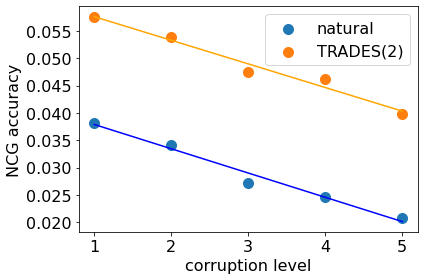

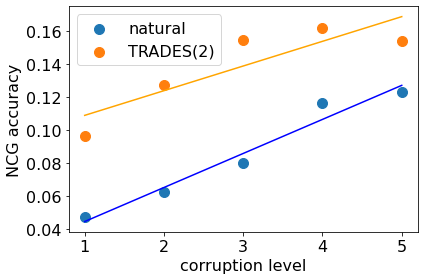

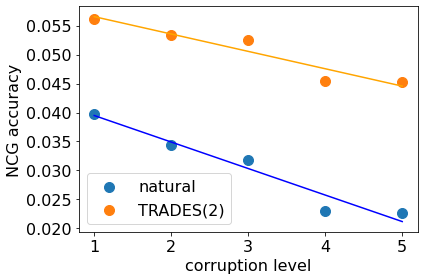

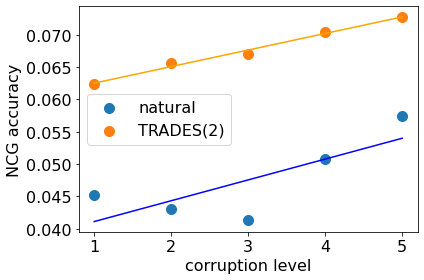

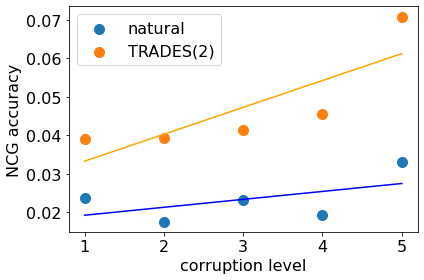

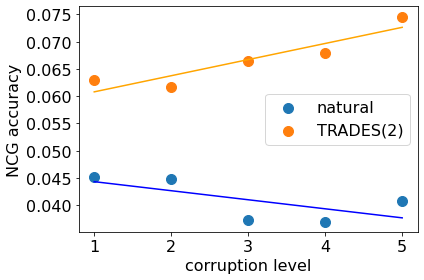

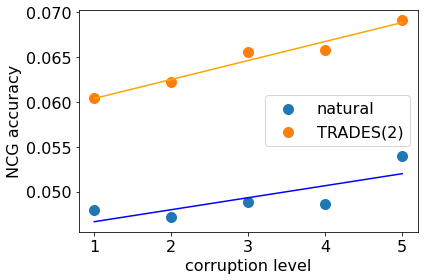

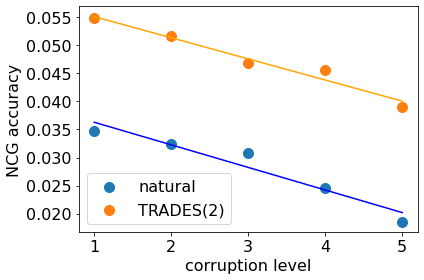

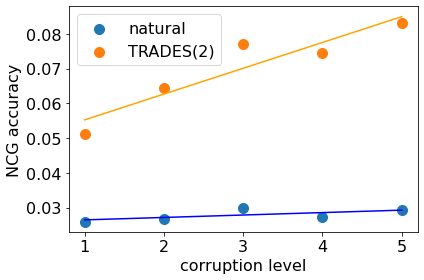

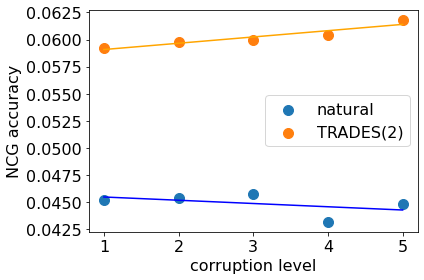

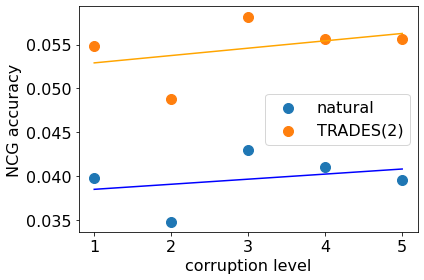

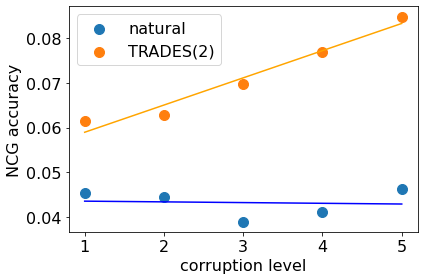

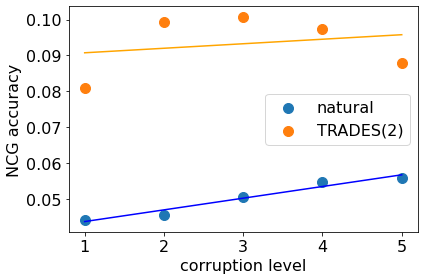

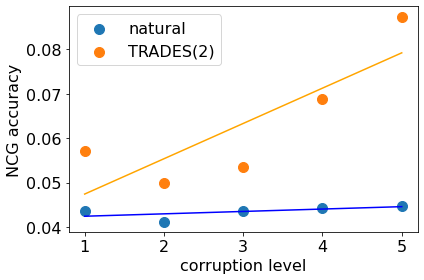

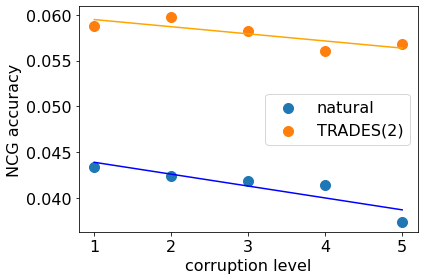

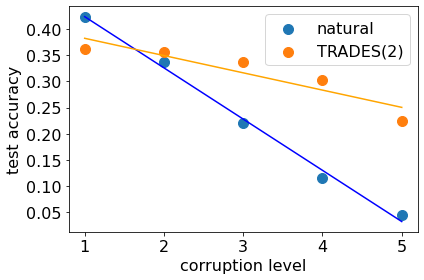

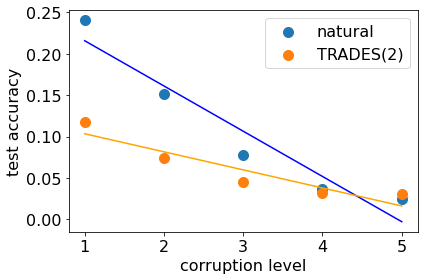

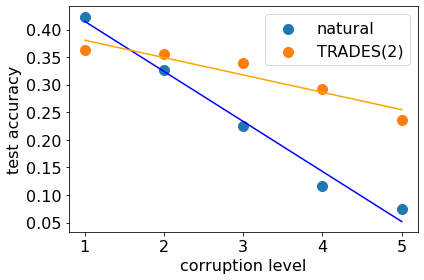

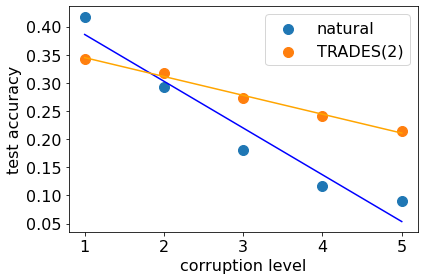

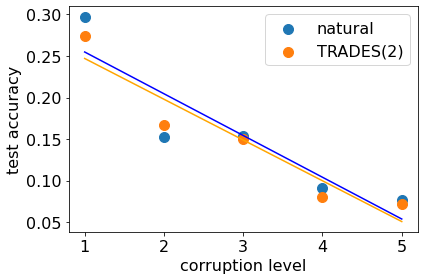

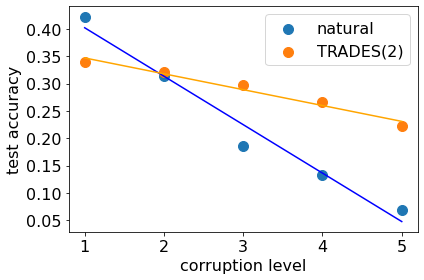

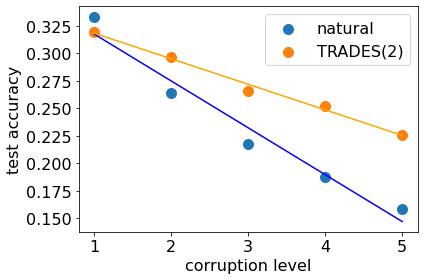

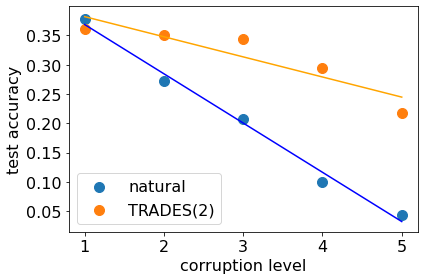

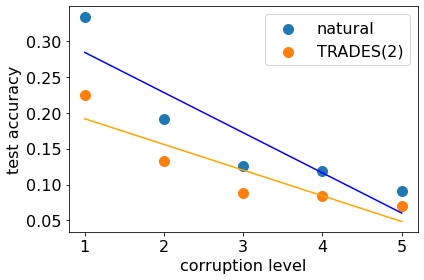

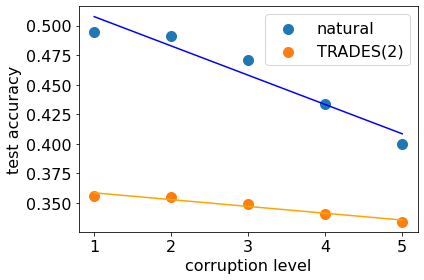

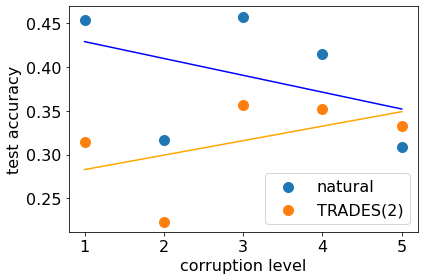

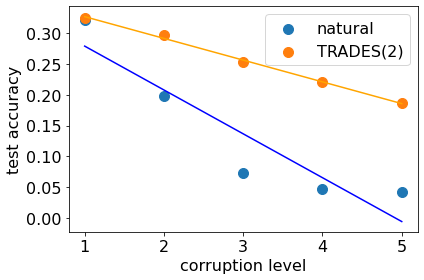

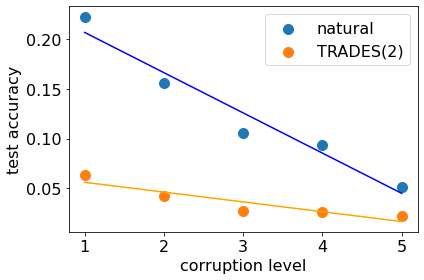

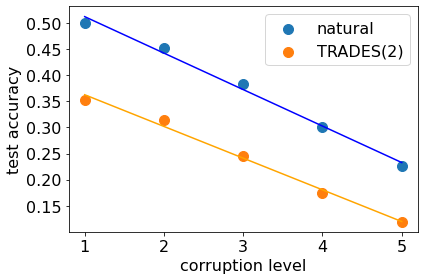

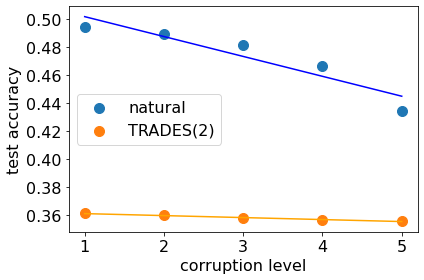

In [27]:
fontsize = 16
ds_names = ['aug10-imgnet100']
for metric in ["ncg", "tstacc"]:
    for ds_name in ds_names:
        for ood_name in set([ent.split("_")[0] for ent in ood_names]):
            if metric == "ncg":
                prefix = ""
            elif metric == "tstacc":
                prefix = "tstacc_"
            points = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[(ds_name, "natural")][[f"{prefix}{ood_name}_{i}" for i in range(1, 6)]].tolist()
            ]).T
            rob_pts = np.array([
                (np.arange(5) / 4).tolist(),
                df.loc[(ds_name, "TRADES(2)")][[f"{prefix}{ood_name}_{i}" for i in range(1, 6)]].tolist(),
            ]).T

            plt.scatter(points[:, 0], points[:, 1], s=100, label="natural")
            plt.scatter(rob_pts[:, 0], rob_pts[:, 1], s=100, label="TRADES(2)")

            def draw_regression_line(pts):
                gradient, intercept, _, _, _ = scipy.stats.linregress(pts[:, 0], pts[:, 1])
                x1=np.linspace(0, 1, 500)
                y1=gradient*x1 + intercept
                return gradient, x1, y1

            slope1, x1, y1 = draw_regression_line(points)
            plt.plot(x1, y1,'blue')
            slope2, x1, y1 = draw_regression_line(rob_pts)
            plt.plot(x1, y1,'orange')

            plt.legend(fontsize=fontsize)
            if metric == "ncg":
                plt.ylabel("NCG accuracy", fontsize=fontsize)
            elif metric == "tstacc":
                plt.ylabel("test accuracy", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            plt.xlabel("corruption level", fontsize=fontsize)
            plt.xticks(np.arange(5) / 4, labels=[1, 2, 3, 4, 5], fontsize=fontsize)
            plt.tight_layout()
            slope1 = f"{slope1:.3f}".replace(".", "_")
            slope2 = f"{slope2:.3f}".replace(".", "_")
            plt.savefig(f"figs/slope_figs/{metric}_{ds_name}_{ood_name}_{slope1}_{slope2}.png", bbox_inches='tight')
            plt.show()


#### distance vs. accuracy

In [9]:
df = pd.DataFrame.from_dict(data, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index)
df = df.unstack(2)
df.columns = df.columns.droplevel(0)

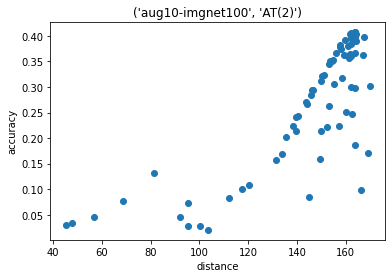

('aug10-imgnet100', 'AT(2)'): rho=0.801, p=0.000


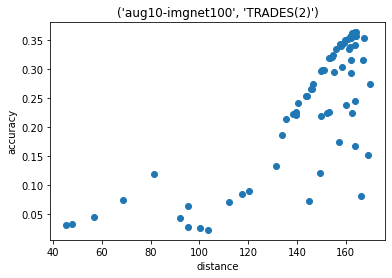

('aug10-imgnet100', 'TRADES(2)'): rho=0.792, p=0.000


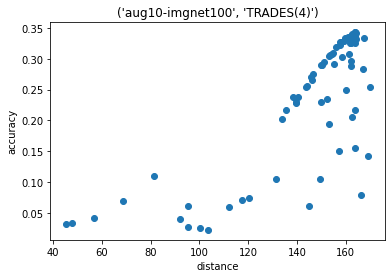

('aug10-imgnet100', 'TRADES(4)'): rho=0.781, p=0.000


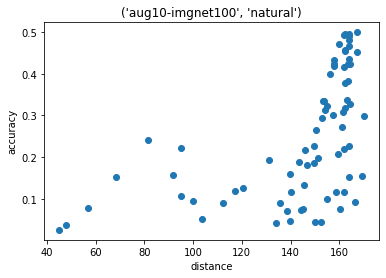

('aug10-imgnet100', 'natural'): rho=0.543, p=0.000


In [12]:
for i in range(4):
    aa = df[[f"dist_{ood_name}" for ood_name in ood_names]].iloc[i].tolist()
    bb = df[[f"tstacc_{ood_name}" for ood_name in ood_names]].iloc[i].tolist()
    plt.title(df.iloc[i].name)
    plt.scatter(aa, bb)
    plt.xlabel("distance")
    plt.ylabel("accuracy")
    plt.savefig(f"figs/slope_figs/{metric}_{ds_name}_{ood_name}_{slope1}_{slope2}.png", bbox_inches='tight')
    plt.show()
    plt.close()
    res = scipy.stats.pearsonr(aa, bb)
    print(f"{df.iloc[i].name[0], df.iloc[i].name[1]}: rho={res[0]:.3f}, p={res[1]:.3f}")

In [11]:
df

brightness_1  brightness_2  brightness_3  \
aug10-imgnet100 AT(2)            0.0524        0.0514        0.0510   
                TRADES(2)        0.0570        0.0500        0.0534   
                TRADES(4)        0.0616        0.0604        0.0638   
                natural          0.0436        0.0412        0.0436   

                           brightness_4  brightness_5  contrast_1  contrast_2  \
aug10-imgnet100 AT(2)            0.0572        0.0750      0.0858      0.1198   
                TRADES(2)        0.0688        0.0874      0.0966      0.1274   
                TRADES(4)        0.0832        0.1040      0.1200      0.1466   
                natural          0.0442        0.0448      0.0472      0.0624   

                           contrast_3  contrast_4  contrast_5  ...  \
aug10-imgnet100 AT(2)          0.1736      0.2638      0.3016  ...   
                TRADES(2)      0.1546      0.1618      0.1542  ...   
                TRADES(4)      0.1664      0.1602      0.1576  ...   
                natural        0.0802      0.1164      0.1234  ...   

                           tstacc_zoom_1  tstacc_zoom_2  tstacc_zoom_3  \
aug10-imgnet100 AT(2)             0.3500         0.3222         0.2932   
                TRADES(2)         0.3190         0.2970         0.2658   
                TRADES(4)         0.3070         0.2894         0.2664   
                natural           0.3334         0.2640         0.2178   

                           tstacc_zoom_4  tstacc_zoom_5  zoom_1  zoom_2  \
aug10-imgnet100 AT(2)             0.2698         0.2406  0.0556  0.0594   
                TRADES(2)         0.2522         0.2254  0.0604  0.0622   
                TRADES(4)         0.2542         0.2280  0.0736  0.0766   
                natural           0.1878         0.1586  0.0480  0.0472   

                           zoom_3  zoom_4  zoom_5  
aug10-imgnet100 AT(2)      0.0572  0.0576  0.0624  
                TRADES(2)  0.0656  0.0658  0.0692  
                TRADES(4)  0.0786  0.0796  0.0832  
                natural    0.0488  0.0486  0.0540  

[4 rows x 226 columns]

# Distance

In [8]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", "aug10-imgnet100")

100%|██████████| 157/157 [00:03<00:00, 46.44it/s] 


In [4]:
preds, nnidxs, dists = joblib.load("nb_results/nowo-imgnet100-c.pkl")
_, ood_names = get_ood_data_paths("imgnet", "/tmp2")
ood_names = set([n[:-2] for n in ood_names])

In [9]:
def get_dist_pred_y(ds_name, model_name):
    ncg_dists = []
    ncg_preds = []
    ncgy = []

    #key = ('aug10-imgnet100', 'natural')
    key = (ds_name, model_name)
    for ood_name in ood_names:
        for i in range(1, 6):
            ncg_dists.append(dists[key][ood_name + f"_{i}"].reshape(-1))
            ncg_preds.append(preds[key][ood_name + f"_{i}"].argmax(1))
            ncgy.append(trny[nnidxs[key][ood_name + f"_{i}"].reshape(-1)])

    ncg_dists = np.concatenate(ncg_dists)
    ncg_preds = np.concatenate(ncg_preds)
    ncgy = np.concatenate(ncgy)
    return ncg_dists, ncg_preds, ncgy

ds_name = "aug10-imgnet100"
data = {}
for model_name in ["natural", "TRADES(2)", "AT(2)"]:
    ncg_dists, ncg_preds, ncgy = get_dist_pred_y(ds_name, model_name)
    data[model_name] = (ncg_dists, ncg_preds, ncgy)

In [10]:
bins = 5
offset = 0
model_name = "nat"

for offset, model_name in enumerate(["natural", "TRADES(2)", "AT(2)"]):
    ncg_dists, ncg_preds, ncgy = data[model_name]
    accs = (ncg_preds == ncgy)
    sort_idx = np.argsort(ncg_dists)

    xticks, xaxis, yaxis, yerrs = [], [], [], []
    for i in range(bins):
        idx = sort_idx[(i * len(sort_idx)) // bins: ((i+1) * len(sort_idx)) // bins]
        xticks.append("%.2f" % ncg_dists[idx].mean())
        xaxis.append(i + (offset-1)*0.2)
        yaxis.append(accs[idx].mean())
        yerrs.append(scipy.stats.sem(accs[idx]))
    plt.bar(xaxis, yaxis, yerr=yerrs, width=0.2, label=model_name)

#plt.title(f"{ds_name}")
plt.xticks(np.arange(bins), xticks, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("NCG accuracy", fontsize=fontsize)
plt.xlabel("Avg. $\ell_2$ dist. to the closest training example", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
#plt.show()
plt.savefig(f"figs/ncg_binned_dists/pixel-corrupted-all_{ds_name}.png", bbox_inches='tight')
plt.close()